In [1]:
import pandas as pd
import numpy as np
import time
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.utils import random
from sklearn.model_selection import train_test_split

from collections import OrderedDict

combined_data = pd.read_hdf("../source_files/combined_data_C1.hdf5")

INPUT_COLUMNS = ["px", "pz", "start_speed", "spin_rate", "spin_dir", "zone", "pitch_type"]
CONTEXT_COLUMNS = ["b_score", "p_score", "b_count", "s_count", "outs", "pitch_num", \
    "on_1b", "on_2b", "on_3b", "inning", "p_throws", "stand", "top"]
OUTPUT_COLUMNS = ["at_bat_score"]

inputs = combined_data[INPUT_COLUMNS].copy()
context = combined_data[CONTEXT_COLUMNS].copy()

#------------- One-Hot Encode  -----------------
inputs = pd.concat([inputs, pd.get_dummies(inputs.pitch_type)], axis=1)
inputs = inputs.drop(labels="pitch_type", axis=1)

context[["p_throws", "stand"]] = context[["p_throws", "stand"]] == "R"
context[["p_throws", "stand", "top"]] = context[["p_throws", "stand", "top"]].astype(int)
context = context.rename(columns={"p_throws":"p_isrighty", "stand":"b_isrighty", "top":"is_top_inning"})

combined_inputs = pd.concat([inputs, context], axis=1)
combined_inputs = torch.tensor(combined_inputs.values)
outputs = torch.tensor(combined_data[OUTPUT_COLUMNS].values)

In [2]:
class FFNetPytorch(nn.Module):
  def __init__(self, input_size, output_size, hidden_size=256):
    super(FFNetPytorch, self).__init__()
    '''
    Define the layers of the neural network. One hidden layer and output layer.
    The activation function used in between the two layers is sigmoid.
    '''
    self.layer1 = nn.Linear(input_size, hidden_size, bias = True)
    self.layer2 = nn.Linear(hidden_size, output_size, bias = True)
    self.double()
    

  def forward(self, x):
    '''
    :param x: input to the model (N, NUM_FEATURES)

    :return:
      output: logits of the last layer of the model 
    '''
    x = torch.sigmoid(self.layer1(x))
    x = self.layer2(x)

    return x

class CustomDataset(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __getitem__(self, i):
    return self.X[i, ...], self.Y[i]
  
  def __len__(self):
    return self.X.shape[0]


Training

In [5]:
#------------- Train --------------
X_train, X_test, Y_train, Y_test = \
    train_test_split(combined_inputs, outputs, test_size=0.2, random_state=42)

NUM_FEATURES = X_train.shape[1]
NUM_CLASSES = 1
HIDDEN_SIZE = 50
#batch_size = 1024
max_epochs = 3
print_every = 1

mini_batches = []
times = []

for e in range(8):
  batch_size = 2**(e+5)
  model = FFNetPytorch(NUM_FEATURES, NUM_CLASSES, hidden_size=HIDDEN_SIZE)
  losses =[]

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
  loss_fn = nn.MSELoss()
  torch.manual_seed(314159)
  device = "cpu"

  dataset_train = CustomDataset(X_train, Y_train)
  dataset_test = CustomDataset(X_test, Y_test)

  model = model.to(device)
  train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  model.train()

  accuracies = []
  total_epochs = max_epochs + len(losses)
  start_time = time.time()
  for epoch in range(max_epochs):  
    batch_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = loss_fn(output, target)
      loss.backward()
      optimizer.step()
      batch_losses.append(loss.item())
    losses.append(torch.mean(torch.Tensor(batch_losses)).item())
    print(f"Epoch: {epoch}, time: {time.time()-start_time}")
  
  end_time = time.time()
  time_elapsed = end_time - start_time

  mini_batches.append(batch_size)
  times.append(time_elapsed/max_epochs)
  print(f"Batch_size = {batch_size}, Time per epoch = {time_elapsed/max_epochs}")





Epoch: 0, time: 50.01072382926941
Epoch: 1, time: 95.41782402992249
Epoch: 2, time: 146.84733605384827
Batch_size = 32, Time per epoch = 48.94914436340332
Epoch: 0, time: 31.915510177612305
Epoch: 1, time: 60.69106411933899
Epoch: 2, time: 91.65121793746948
Batch_size = 64, Time per epoch = 30.550445318222046
Epoch: 0, time: 20.60319423675537
Epoch: 1, time: 46.164302110672
Epoch: 2, time: 66.74497628211975
Batch_size = 128, Time per epoch = 22.248362461725872
Epoch: 0, time: 17.61821484565735
Epoch: 1, time: 36.43564009666443
Epoch: 2, time: 54.4528489112854
Batch_size = 256, Time per epoch = 18.150980949401855
Epoch: 0, time: 15.555701732635498
Epoch: 1, time: 30.935933828353882
Epoch: 2, time: 46.07291579246521
Batch_size = 512, Time per epoch = 15.357678333918253
Epoch: 0, time: 15.548192024230957
Epoch: 1, time: 30.95949387550354
Epoch: 2, time: 46.665865898132324
Batch_size = 1024, Time per epoch = 15.555333296457926
Epoch: 0, time: 16.246941089630127
Epoch: 1, time: 32.402441024

Text(0, 0.5, 'Time per epoch')

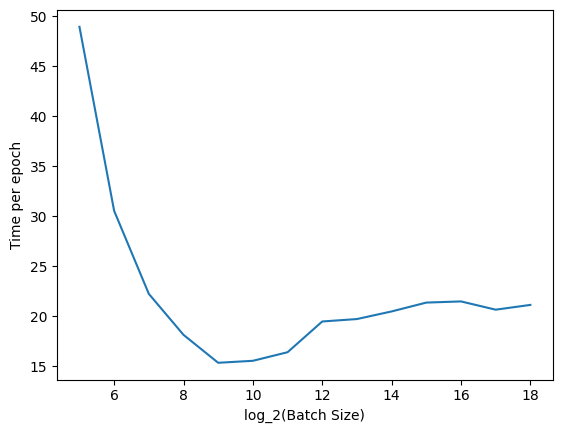

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(np.log(mini_batches)/np.log(2), np.array(times)/max_epochs)
plt.xlabel("log_2(Batch Size)")
plt.ylabel("Time per epoch")

In [12]:
model = model.to(device)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
losses = []
accuracies = []
model.eval()
batch_losses = []

for batch_idx, (data, target) in enumerate(test_loader):
  data, target = data.to(device), target.to(device)
  output = model(data)
  loss = loss_fn(output, target)
  prediction = torch.argmax(output, dim=1)
  batch_losses.append(loss.item())

test_loss = torch.mean(torch.Tensor(batch_losses)).item()
print(f'Test_loss = {test_loss} ')

Test_loss = 3.580965995788574 
